# Simulation-based inference with normalizing flows

## Three body problem

We are going to estimate masses of three bodies interacting gravitationally given some noisy observation of their trajectories over a period of time. 

In [18]:
import numpy as np
import rebound
import torch
from torch import Tensor

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%matplotlib inline


def simulate_three_body_problem(
    masses: tuple, 
    coords: tuple,
    velocities: tuple,
    total_time: float = 1.0, 
    num_steps: int = 100,
):
    
    """
    Simulates the three-body problem using the REBOUND library with IAS15 integrator.
    
    Parameters:
    -----------
    masses : list of float
        The masses of the three bodies. Defaults to [1.0, 1e-3, 1e-3].
        
        
    total_time : float
        The total time to simulate. Defaults to 100.0.
        
    num_steps : int
        The number of time steps to record. Defaults to 1000.
        
    Returns:
    --------
    time : np.ndarray
        Array of time points.
        
    trajectories : np.ndarray
        Array of shape (num_steps, 3, 3) containing the positions of the three bodies at each time step.
    """
    

    # Create the simulation
    sim = rebound.Simulation()
        
    # Add the bodies
    for mass, (x, y, z), (vx, vy, vz)  in zip(masses, coords, velocities):
        sim.add(
            m=mass,
            x=x, 
            y=y, 
            z=z, 
            vx=vx,
            vy=vy, 
            vz=vz,
        )
        
        
    # Set the integrator and time step
    sim.integrator = "IAS15"
    sim.dt = total_time / num_steps

    # Arrays to store the trajectories
    time = np.linspace(0, total_time, num_steps)
    trajectories = np.zeros((num_steps, 3, 3))  # shape (time steps, particles, coordinates)
    
    # Run the simulation and store the trajectories
    for i, t in enumerate(time):
        sim.integrate(t)
        for j, particle in enumerate(sim.particles):
            trajectories[i, j, 0] = particle.x
            trajectories[i, j, 1] = particle.y
            trajectories[i, j, 2] = particle.z
    
    return trajectories


def simulator_step(masses: Tensor):
    masses = masses.tolist()

    init_coords = np.array([
        (0.9, 0.1, 0.1),
        (-0.8, 0, 0),
        (0., -0.2, 0.2),
    ])

    init_velocities = np.array([
        (0.01, -0.2, 0.2),
        (0., 0.02, -0.1),
        (-0.03, 0.05, .08),
    ])

    # priors on initial velocities (normal distribution)
    init_velocities += np.random.normal(0, 0.02, (3, 3))

    # priors on initial coordinates (normal distribution)
    init_coords += np.random.normal(0, 0.02, (3, 3))

    trajectories = simulate_three_body_problem(masses, velocities=init_velocities, coords=init_coords)

    return trajectories2noisy_observations(trajectories)


def simulator(batch_size: int):
    # prior on masses (uniform distribution U(1, 100))
    masses = torch.rand(batch_size, 3) * 99 + 1
    simulations = torch.stack([simulator_step(mass) for mass in tqdm(masses)])

    return simulations, masses


def trajectories2noisy_observations(trajectories, std: float = 0.01):
    xy_coords = torch.from_numpy(trajectories[..., :2]).float()
    xy_coords = xy_coords + torch.randn_like(xy_coords) * std
    return xy_coords


def show_observation(observation):
    if observation.ndim == 4:
        observation = observation[0]
    
    for i in range(3):
        plt.plot(observation[:, i, 0].cpu().numpy(), observation[:, i, 1].cpu().numpy(), 'o-', markersize=2)
    plt.show()

# Observation

Here is the observation that we would like to analyse:

In [ ]:
import requests
import numpy as np
import io

file_url = 'https://raw.githubusercontent.com/StarostinV/nflows-hands-on/main/three-body-problem-observation.csv'

response = requests.get(file_url)
if response.status_code == 200:
    # Read the CSV content into a NumPy array
    file_content = response.content
    target_data = np.loadtxt(io.BytesIO(file_content), delimiter=',')
    
else:
    print('Failed to download the file:', response.status_code)


target_data = torch.from_numpy(target_data).float().view(100, 3, 2)s


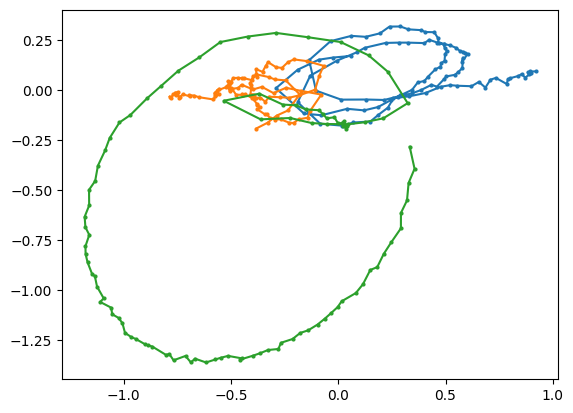

In [15]:
show_observation(target_data)

We have a simulator that produces observations like the one that we have by sampling parameters from the prior distribution (including masses, initial coordinates and initial velocities)

In [20]:
observations, masses = simulator(10)

  0%|          | 0/100 [00:00<?, ?it/s]

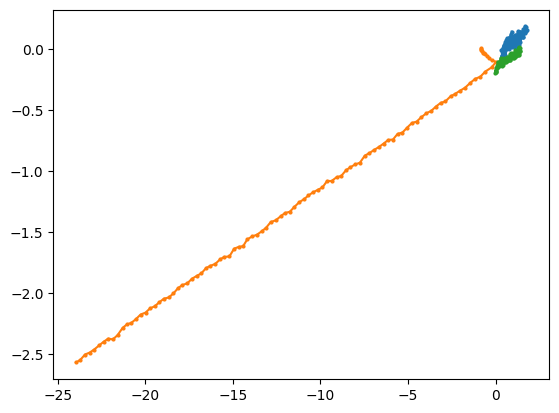

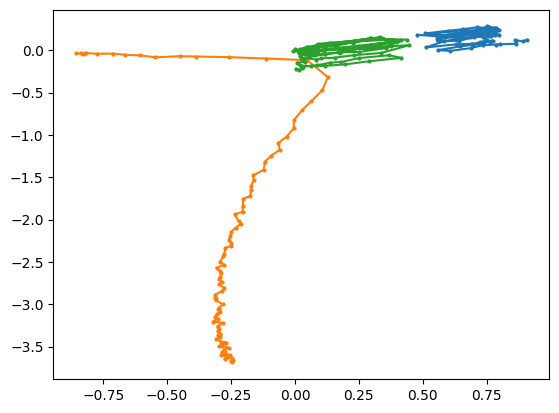

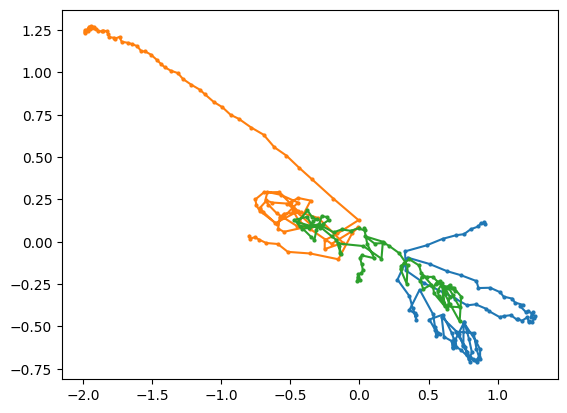

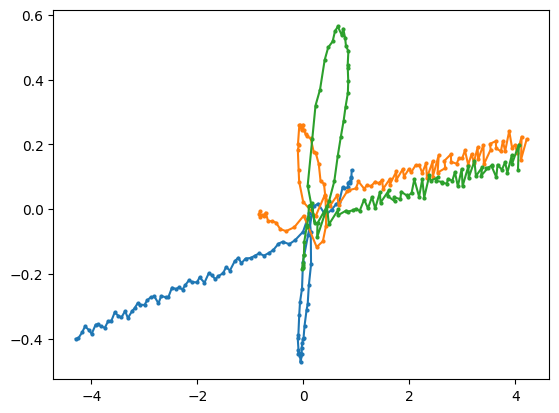

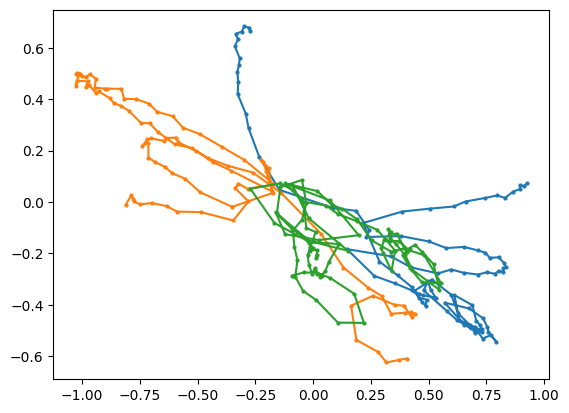

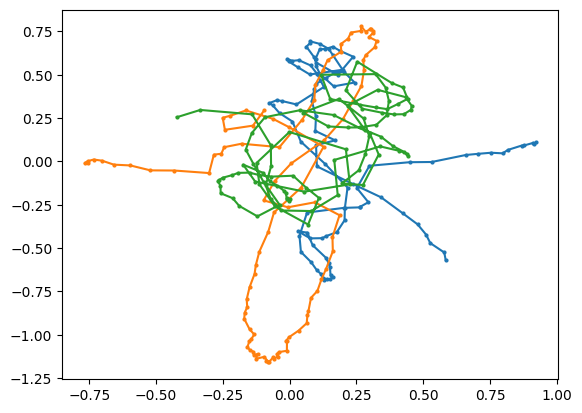

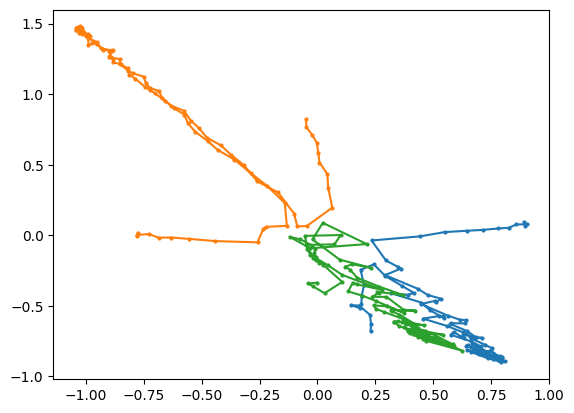

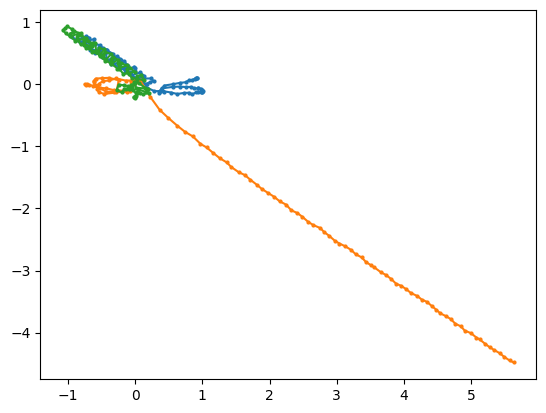

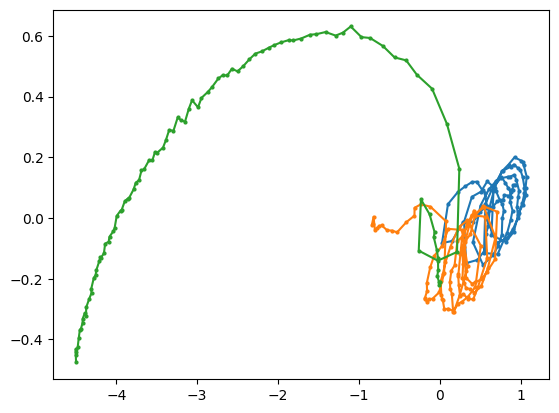

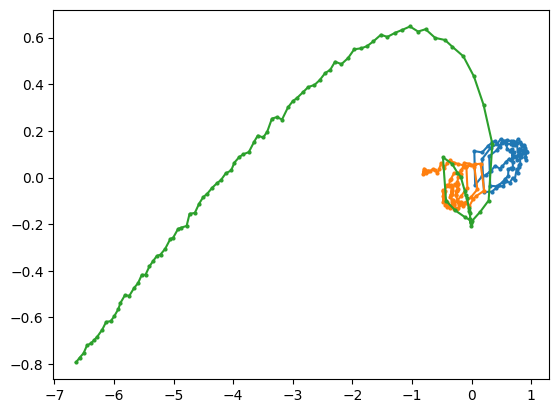

In [21]:
for batch_idx in range(10):

    show_observation(observations[batch_idx])

# Build the flow-based model

In [23]:
# TODO: use nflows to build a flow-based model to predict 3 masses 
# given the context in the form of the simulated observations.

# Train

In [ ]:
# TODO: train the model

# Visualize distribution

In [ ]:
# TODO: sampled_masses from the flows given the data

target_data = torch.load('three-body-problem-observation.pt')

# sample from the trained flow 

In [ ]:
# plot distributions of the masses

import seaborn as sns
import pandas as pd

df = pd.DataFrame(sampled_masses, columns=['m1', 'm2', 'm3'])

sns.pairplot(df)